In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plumed
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import math
import MDAnalysis as mda
from MDAnalysis.analysis.rms import RMSD
from MDAnalysis.analysis.rms import RMSF

# RMSD calculation

For reasons of consistency, I have to align both the atomistic structure and the CG structure with respect to the backbone. The problem with the CG system is that gromacs does not recognize the BB atoms. Therefore I have to create a index with `a BB`. For simplicity I also make an entry for the calcium ions (with their indices) `a 484-485`. Remember you have to compose your newly formed Ca2+ group with the protein, otherwise you cannot save the output with trjconv. 

Next, select the `BB` for the rot+trans fit and `Protein_CAL` for output.

In [54]:
PDB = 'start_prot_CAL.pdb'
XTC = 'trj_fit_BB_CAL.xtc'
u = mda.Universe(str(PDB), str(XTC)) #we create the universe

PDB_aa = 'AA_sim/ref_nowat.pdb'
XTC_aa = 'AA_sim/trj_fit_BB.xtc'
u_aa = mda.Universe(str(PDB_aa), str(XTC_aa))


/Users/giuseppegambini/.local/lib/python3.8/site-packages/MDAnalysis/topology/PDBParser.py:328: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


# EF2 Pocket behaviour

In [9]:
pocket = "resid 70-90 and name BB"  
sel_pocket = u.select_atoms(pocket)

rmsd_pocket = mda.analysis.rms.RMSD(sel_pocket).run()
rmsd_BB = mda.analysis.rms.RMSD(u.select_atoms("name BB")).run()

/Users/giuseppegambini/.local/lib/python3.8/site-packages/MDAnalysis/analysis/rms.py:718: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


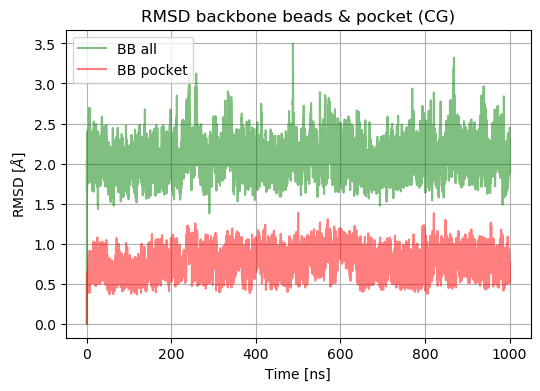

In [67]:
plt.rcParams["figure.figsize"] = (6, 4)
rmsd_pocket_values = rmsd_pocket.rmsd.T   # transpose makes it easier for plotting
rmsd_BB_values = rmsd_BB.rmsd.T   # transpose makes it easier for plotting
time = rmsd_BB_values[1]
plt.plot(time*0.001, rmsd_BB_values[2], 'g-',  label="BB all", alpha=0.5)
plt.plot(time*0.001, rmsd_pocket_values[2], 'r-',  label="BB pocket", alpha=0.5)
plt.ylabel(r"RMSD $[\AA]$")
plt.grid()
plt.legend(loc="best")
plt.title("RMSD backbone beads & pocket (CG)")
plt.xlabel("Time [ns]")
plt.savefig("pics/RMSD_cg.png")

# Comparison with AA

# Atomistic RMSD
After the removal of roto-translational backbone motions. 

We have to be consistent with the COG prescription of Martini3. Hence, we define an ad hoc selection.

In [56]:
mda.RMSD?

Object `mda.RMSD` not found.


In [39]:
#rmsd_BB = mda.analysis.rms.RMSD(u.select_atoms("name BB")).run()
rmsd_COG = mda.analysis.rms.RMSD(u_aa.select_atoms("backbone and name HA HA1 HA2 HB HB1 HB2 HN")).run()

In [52]:
pocket = "resid 70-90 and backbone"  
sel_pocket_aa = u_aa.select_atoms(pocket)

rmsd_pocket_aa = mda.analysis.rms.RMSD(sel_pocket_aa).run()

/Users/giuseppegambini/.local/lib/python3.8/site-packages/MDAnalysis/analysis/rms.py:718: DeprecationWarning: The `rmsd` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


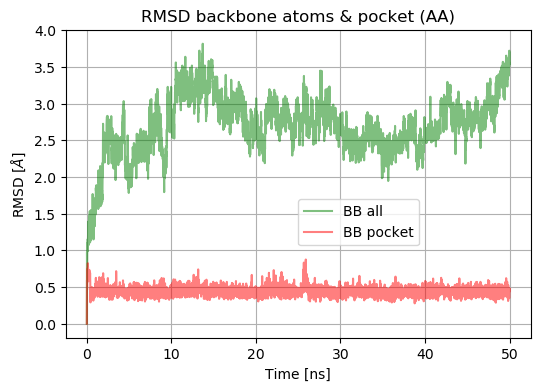

In [66]:
rmsd_BB_aa_values = rmsd_BB_aa.rmsd.T   # transpose makes it easier for plotting
rmsd_BB_pocket_values = rmsd_pocket_aa.rmsd.T 
time = rmsd_BB_aa_values[1]
plt.plot(time*0.001, rmsd_BB_aa_values[2], 'g-',  label="BB all", alpha=0.5)
plt.plot(time*0.001, rmsd_BB_pocket_values[2], 'r-',  label="BB pocket", alpha=0.5)
plt.ylabel(r"RMSD $[\AA]$")
plt.grid()
plt.legend(loc=[0.5, 0.3])
plt.title("RMSD backbone atoms & pocket (AA)")
plt.xlabel("Time [ns]")
plt.savefig("RMSD_aa.png")

# RMSD with COG

In [ ]:
cog_coordinates_ref = []
for i in range(len(u_aa.select_atoms("protein").residues)):
    residue_group = u_aa.select_atoms(f"resid {i+2} and name CA N C O HA HA1 HA2 HB HB1 HB2 HN")
    cog_coordinates_ref.append(residue_group.center_of_geometry())

# Root mean square fluctuation (RMSF)

In [16]:
# devo distinguere la rmsd della backbone da quella totale 
# (che comprende anche le side-chains) 

BB = u.select_atoms("name BB")
myRMSF_bb = RMSF(BB).run()

/Users/giuseppegambini/.local/lib/python3.8/site-packages/MDAnalysis/analysis/rms.py:887: DeprecationWarning: The `rmsf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)
/Users/giuseppegambini/.local/lib/python3.8/site-packages/MDAnalysis/analysis/rms.py:887: DeprecationWarning: The `rmsf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


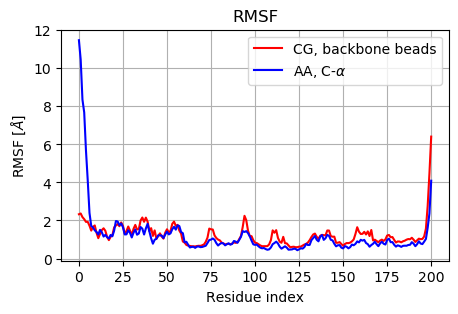

In [50]:
# potrei confrontare questa con quella AA

plt.rcParams["figure.figsize"] = (5, 3)
plt.plot(myRMSF_bb.rmsf, 'r', label="CG, backbone beads")
plt.plot(myRMSF_CA_aa.rmsf, 'b', label=r"AA, C-$\alpha$")
plt.xlabel('Residue index')
plt.ylabel(r'RMSF [$\AA$]')
plt.title('RMSF')
plt.legend(loc='best')
plt.grid()

# Tieni conto che in realtà dovresti plottare la RMSF 
# rispetto agli atomi della backbone. 

In [81]:
len(u_aa.select_atoms("protein").residues)

201

Ora qui stai attento perché Martini3 usa il centro di geometria degli atomi della backbone e pure gli idrogeni. I nomi degli idrogeni coinvolti sono `HA`, `HA1`, `HA2`, `HB`, `HB1`, `HB2`, `HN`. 

In [69]:

rmsf_cog = []

# Compute the CM of the reference configuration (frame zero)
cog_coordinates_ref = []
for i in range(len(u_aa.select_atoms("protein").residues)):
    residue_group = u_aa.select_atoms(f"resid {i+2} and name CA N C O HA HA1 HA2 HB HB1 HB2 HN")
    cog_coordinates_ref.append(residue_group.center_of_geometry())

In [70]:
# Puoi fare delle prove con pochi residui per volta...

N_res = len(u_aa.select_atoms("protein").residues)

for i in range(N_res):
    residue_group = u_aa.select_atoms(f"resid {i+2} and name CA N C O HA HA1 HA2 HB HB1 HB2 HN")

    # define the array of positions 
    cog_coordinates = np.zeros((len(u_aa.trajectory), 3))

    # Loop for the RMSF of a single residue 
    for ts in u_aa.trajectory:
        # Compute center of mass of the selected residue 
        cog_coordinates[ts.frame] = residue_group.center_of_geometry()

    # Compute the RMSF for the single residue    
    rmsf_cog.append(np.mean(np.square(cog_coordinates - cog_coordinates_ref[i]), axis=0))
    print(f"RMSF of residue {i+2} computed")


# Nel caso dovesse esserci un errore ricordati che la numerazione dei 
# residui nella tua proteina è strana e parte da 2. Di conseguenza
# fai attenzione agli estremi del ciclo.


RMSF of residue 2 computed
RMSF of residue 3 computed
RMSF of residue 4 computed
RMSF of residue 5 computed
RMSF of residue 6 computed
RMSF of residue 7 computed
RMSF of residue 8 computed
RMSF of residue 9 computed
RMSF of residue 10 computed
RMSF of residue 11 computed
RMSF of residue 12 computed
RMSF of residue 13 computed
RMSF of residue 14 computed
RMSF of residue 15 computed
RMSF of residue 16 computed
RMSF of residue 17 computed
RMSF of residue 18 computed
RMSF of residue 19 computed
RMSF of residue 20 computed
RMSF of residue 21 computed
RMSF of residue 22 computed
RMSF of residue 23 computed
RMSF of residue 24 computed
RMSF of residue 25 computed
RMSF of residue 26 computed
RMSF of residue 27 computed
RMSF of residue 28 computed
RMSF of residue 29 computed
RMSF of residue 30 computed
RMSF of residue 31 computed
RMSF of residue 32 computed
RMSF of residue 33 computed
RMSF of residue 34 computed
RMSF of residue 35 computed
RMSF of residue 36 computed
RMSF of residue 37 computed


In [71]:
RMSF_aa = []

N_res = len(u_aa.select_atoms("protein").residues)

for i in range(N_res):
    RMSF_aa.append(math.sqrt(rmsf_cog[i][0] + rmsf_cog[i][1] + rmsf_cog[i][2]))

/Users/giuseppegambini/.local/lib/python3.8/site-packages/MDAnalysis/analysis/rms.py:887: DeprecationWarning: The `rmsf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


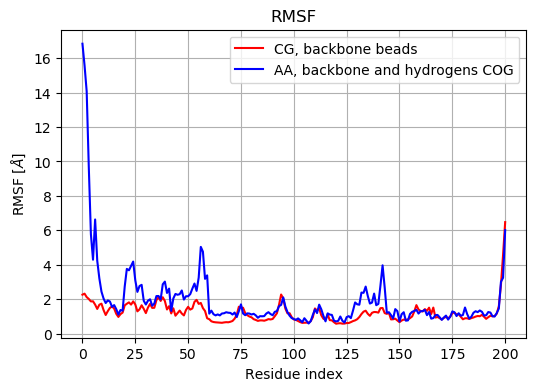

In [73]:
# plot 
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(myRMSF_bb.rmsf, 'r', label="CG, backbone beads")
plt.plot(RMSF_aa, 'b', label="AA, backbone and hydrogens COG")
plt.xlabel('Residue index')
plt.ylabel(r'RMSF [$\AA$]')
plt.title('RMSF')
plt.legend(loc='best')
plt.grid()
plt.savefig("pics/RMSF_AA_CG.png")

# Qui la RMSF atomistica potrebbe migliorare con la simulazione da 50 ns. 
# Il primo residuo è un loop, quindi è anche normale che si muova tanto.
# Potrebbe essere che il residuo CG corrispondente si muova relativamente poco a causa
# della rete elastica. 

In [32]:
len(RMSF_aa)

201

/Users/giuseppegambini/.local/lib/python3.8/site-packages/MDAnalysis/analysis/rms.py:887: DeprecationWarning: The `rmsf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


<function ndarray.mean>

/Users/giuseppegambini/.local/lib/python3.8/site-packages/MDAnalysis/analysis/rms.py:887: DeprecationWarning: The `rmsf` attribute was deprecated in MDAnalysis 2.0.0 and will be removed in MDAnalysis 3.0.0. Please use `results.rmsd` instead.
  warnings.warn(wmsg, DeprecationWarning)


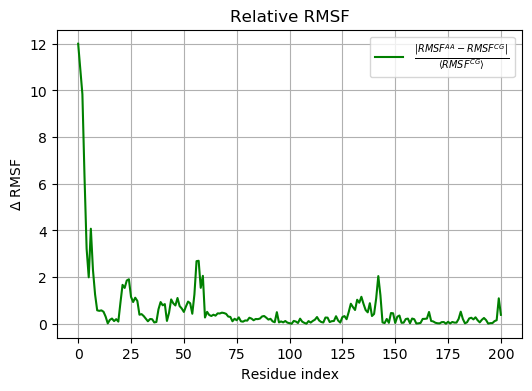

In [78]:
Delta_RMSF = []
N_res = len(u_aa.select_atoms("protein").residues)

mean = 0
for i in range(N_res):
    mean += myRMSF_bb.rmsf[i]/N_res

for i in range(N_res):
    Delta_RMSF.append(math.fabs(RMSF_aa[i]-myRMSF_bb.rmsf[i])/mean)

plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(Delta_RMSF, 'g', label=r"$\frac{|RMSF^{AA}-RMSF^{CG}|}{\langle RMSF^{CG} \rangle}$")
plt.xlabel('Residue index')
plt.ylabel(r'$\Delta$ RMSF')
plt.title(r'Relative RMSF')
plt.legend(loc='best')
plt.grid()
plt.savefig("pics/Delta_RMSF.png")

I want to do a plot with the RMSF of the CM of the backbone atoms (C, CA and N) compared with both the CG RMSF and the beta factors of the Ca $^{2+}$-bound structure of the non-myristoylated bovine recoverin (PDB 4MLW). 

# Radius of gyration (Rg)

The radius of gyration is defined as 
$$
R_g=\sqrt{\frac{\sum_i m_i \mathbf{r}_i^2}{\sum_i m_i}}
$$

The radius of gyration is a measure of the globularity of a protein. It is defined as the root mean square deviation of the position of the atoms with respect to the center of mass of the protein.

$R_g^{2} = \frac{1}{N} \sum_{i=1}^{N}({\bf r_i} - {\bf r_c})^2$

NB: in this approximation all the masses are assumed to be equal. In the case of heavy atoms of proteins this assumption is pretty much satisfied.

In [27]:
# Radius of gyration of the backbone beads
BB = u.select_atoms("name BB")
Rgyr = []
for ts in u.trajectory:
    Rgyr.append(BB.radius_of_gyration())

BB_aa = u_aa.select_atoms("name C CA N")
Rgyr_aa = []
for ts in u_aa.trajectory:
    Rgyr_aa.append(BB_aa.radius_of_gyration())

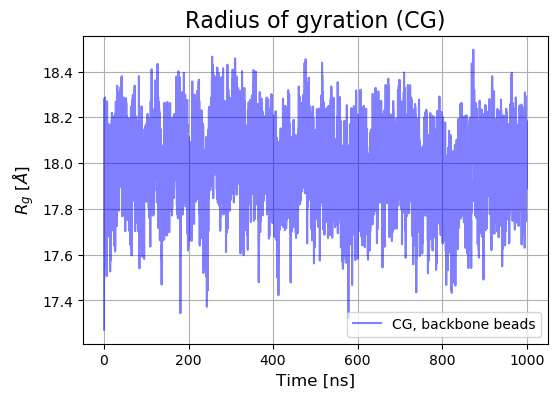

In [37]:
# qua bisogna tenere conto del mapping... La differenza è dovuta
# al fatto che il centro della bead non è proprio 

time = rmsd_BB_values[1]
plt.rcParams["figure.figsize"] = (6, 4)
plt.plot(time*0.001, Rgyr, 'b', label="CG, backbone beads", alpha = 0.5)
plt.legend(loc="best")
plt.title("Radius of gyration (CG)",fontsize=16)
plt.xlabel("Time [ns]",fontsize=12)
plt.ylabel(r"$R_g$ [$\AA$]",fontsize=12)
plt.grid()
plt.savefig("pics/Rg_CG.png")

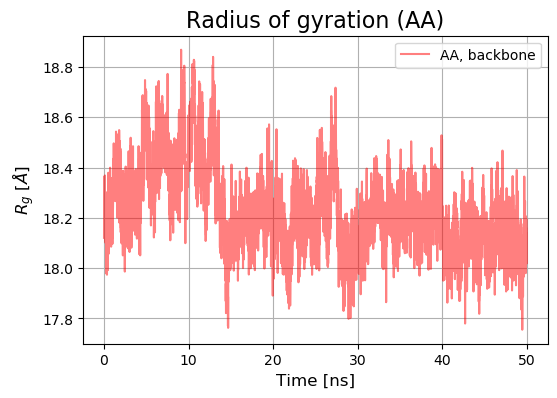

In [42]:
plt.rcParams["figure.figsize"] = (6, 4)
time = rmsd_BB_aa_values[1]
plt.plot(time*0.001, Rgyr_aa, 'r', label="AA, backbone",  alpha = 0.5)
plt.legend(loc="best")
plt.title("Radius of gyration (AA)",fontsize=16)
plt.xlabel("Time [ns]",fontsize=12)
plt.ylabel(r"$R_g$ [$\AA$]",fontsize=12)
plt.grid()
plt.savefig("pics/Rg_AA.png")

# SASA and number of contacts with mindist

It is a measure of the surface area of a biomolecule. It is defined as the extent to which atoms on the surface of a protein can form contact with the solvent, and it is generally measured in squared nanometers. 

The molecular surface is the envelope of the molecular volume from which solvent is excluded. 

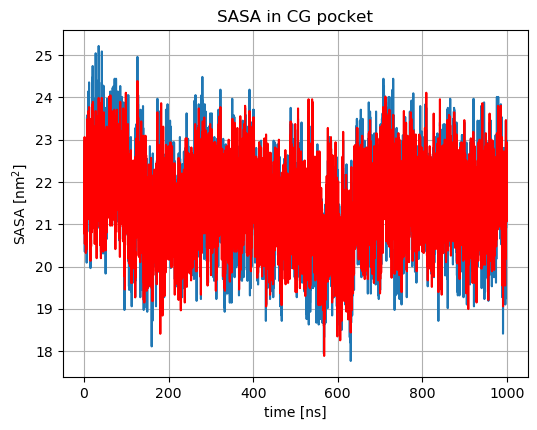

In [28]:
times,sasa_CG = np.loadtxt("sasa_CG.xvg",comments=["@", "#"],unpack=True)
plt.plot(times*0.001, sasa_CG)
plt.plot(times*0.001, sasa, 'r')
plt.xlabel("time [ns]")
plt.ylabel(r"SASA [nm$^2$]")
plt.title("SASA in CG pocket")
plt.grid()
#plt.savefig("SASA.png", format="png", dpi=300)
plt.show()

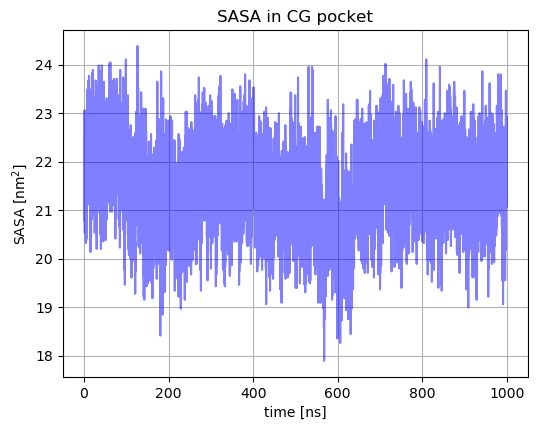

In [49]:
# gmx sasa -f protein.pdb -s protein.pdb -o sasa.xvg 
# gmx sasa -s dynamic_prot_CAL.tpr -f trj_fit_BB_CAL.xtc -o sasa.xvg -n index_pocket.ndx 
times,sasa = np.loadtxt("sasa.xvg",comments=["@", "#"],unpack=True)
plt.plot(times*0.001, sasa, "b", alpha=0.5)
plt.xlabel("time [ns]")
plt.ylabel(r"SASA [nm$^2$]")
plt.title("SASA in CG pocket")
plt.grid()
plt.savefig("SASA_CG.png", format="png")
plt.show()


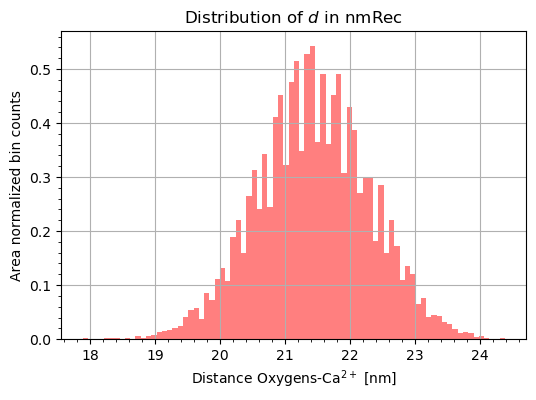

In [17]:
plt.rcParams["figure.figsize"] = (6, 4)
times,sasa = np.loadtxt("sasa.xvg",comments=["@", "#"],unpack=True)
plt.hist(sasa, bins=80, density=True, alpha = 0.5, color= 'r', label="nmRec")
plt.xlabel(r"Distance Oxygens-Ca$^{2+}$ [nm]")
plt.ylabel("Area normalized bin counts")
plt.title(r"Distribution of $d$ in nmRec")
plt.grid()
plt.minorticks_on()

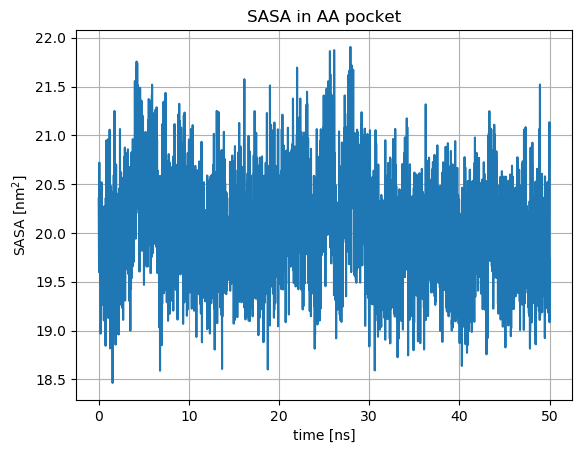

In [15]:
# gmx sasa -s md_nowat.tpr -f trj_fit_BB.xtc -o sasa_AA.xvg -n index_pocket.ndx

times,sasa_AA = np.loadtxt("AA_sim/sasa_AA.xvg",comments=["@", "#"],unpack=True)
plt.plot(times*0.001, sasa_AA)
plt.xlabel("time [ns]")
plt.ylabel(r"SASA [nm$^2$]")
plt.title("SASA in AA pocket")
plt.grid()
#plt.savefig("SASA.png", format="png", dpi=300)
plt.show()

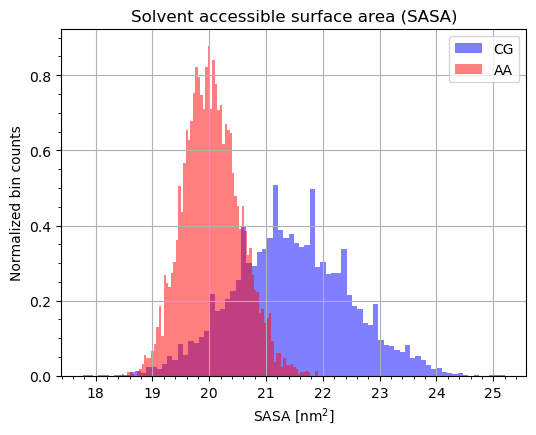

In [50]:
# Posso fare l'istogramma 
plt.rcParams["figure.figsize"] = (6, 4.5)
times,sasa_CG = np.loadtxt("sasa_CG.xvg",comments=["@", "#"],unpack=True)
times,sasa_AA = np.loadtxt("AA_sim/sasa_AA.xvg",comments=["@", "#"],unpack=True)
plt.hist(sasa_CG, bins=80, density=True, alpha = 0.5, color= 'b', label="CG")
plt.hist(sasa_AA, bins=80, density=True, alpha = 0.5, color= 'r', label="AA")
plt.title(r"Solvent accessible surface area (SASA)")
plt.ylabel("Normalized bin counts")
plt.xlabel(r"SASA [nm$^{2}$]")
plt.legend(loc="best")
plt.grid()
plt.minorticks_on()
plt.savefig("pics/sasa.png")

## Mindist 
`gmx mindist`computes the distance between one group and a number of other groups. Both the minimum distance (between any pair of atoms from the respective groups) and the number of contacts within a given distance are written to two separate output files. 
```
gmx mindist -f trj_fit_BB_CAL.xtc -s dynamic_prot_CAL.tpr -n index_mindist.ndx 
```

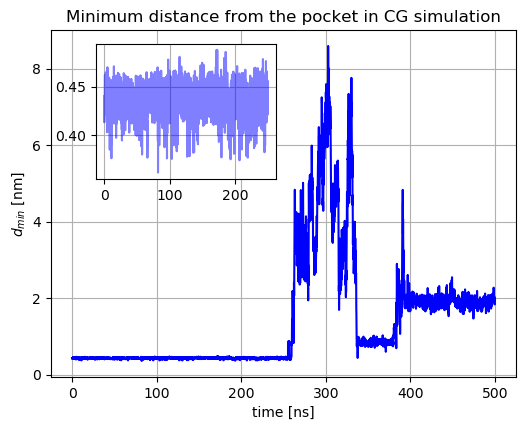

In [52]:
# CG case: 
times,mindist = np.loadtxt("mindist.xvg",comments=["@", "#"],unpack=True)
plt.plot(times[0:5000]*0.001, mindist[0:5000], "b")
plt.xlabel("time [ns]")
plt.ylabel(r"$d_{min}$ [nm]")
plt.title("Minimum distance from the pocket in CG simulation")
plt.grid()

sub_axes = plt.axes([.20, .55, .3, .3]) 
sub_axes.grid()
sub_axes.plot(times[0:2500]*0.001, mindist[0:2500], 'b', alpha=0.5)

plt.savefig("pics/d_min_CG.png")
plt.show()

# qua ci sta fare un ingrandimento sui primi 250 ns. 

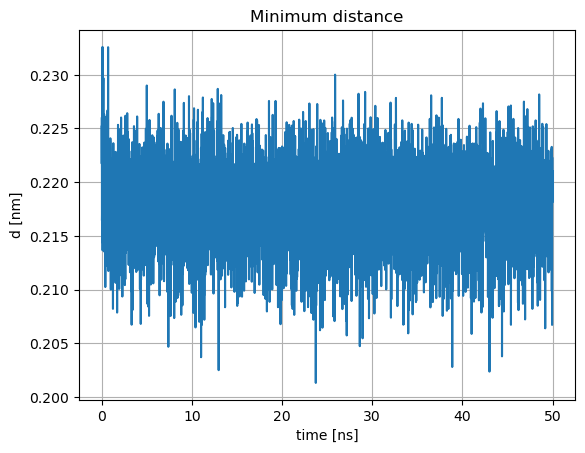

In [7]:
# AA case 
times,mindist_AA = np.loadtxt("AA_sim/mindist.xvg",comments=["@", "#"],unpack=True)
plt.plot(times*0.001, mindist_AA)
plt.xlabel("time [ns]")
plt.ylabel(r"d [nm]")
plt.title("Minimum distance")
plt.grid()
#plt.savefig("SASA.png", format="png", dpi=300)
plt.show()

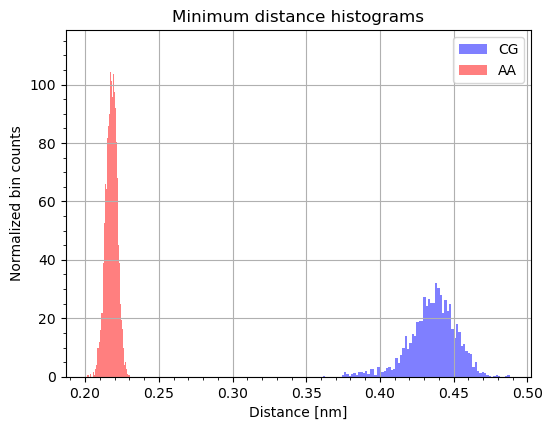

In [53]:
plt.rcParams["figure.figsize"] = (6, 4.5)
times,mindist_CG = np.loadtxt("mindist.xvg",comments=["@", "#"],unpack=True)
times,mindist_AA = np.loadtxt("AA_sim/mindist.xvg",comments=["@", "#"],unpack=True)
plt.hist(mindist_CG[0:2000], bins=80, density=True, alpha = 0.5, color= 'b', label="CG")
plt.hist(mindist_AA, bins=80, density=True, alpha = 0.5, color= 'r', label="AA")
plt.title(r"Minimum distance histograms")
plt.ylabel("Normalized bin counts")
plt.xlabel(r"Distance [nm]")
plt.legend(loc="best")
plt.grid()
plt.minorticks_on()
plt.savefig("pics/distr_d_min.png")

In [13]:
math.pow(2, 1/6)*0.41/2

0.23010471990342146

AttributeError: 'numpy.ndarray' object has no attribute 'get_array'

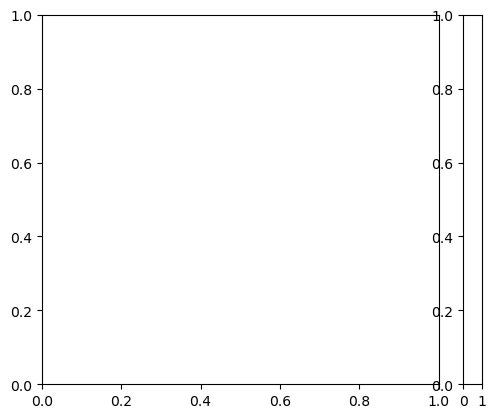

In [9]:
fig, ax = plt.subplots()
fig.colorbar(mappable=sasa, ax=ax, orientation='vertical')

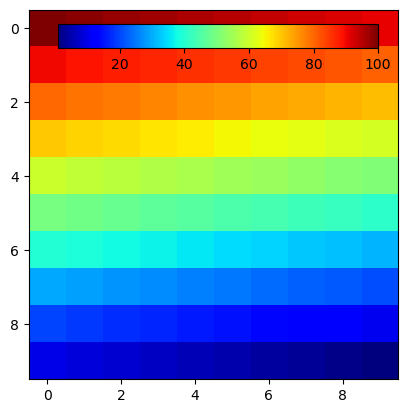

In [29]:
data = np.arange(100, 0, -1).reshape(10, 10)

fig, ax = plt.subplots()
cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])

im = ax.imshow(data, cmap='jet', alpha=1)
plt.colorbar(im, cax=cax, orientation='horizontal')

plt.show()

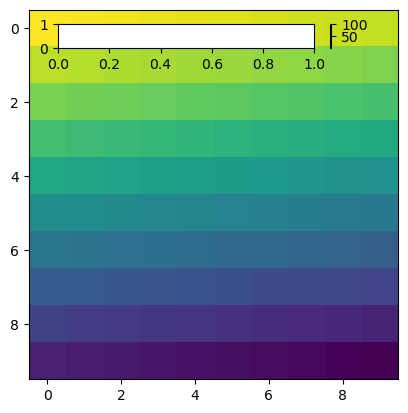

In [20]:
data = np.arange(100, 0, -1).reshape(10, 10)

fig, ax = plt.subplots()
cax = fig.add_axes([0.27, 0.8, 0.5, 0.05])

#im = ax.imshow(data, cmap='blue_red', alpha=0.5)
im = ax.imshow(data)
plt.colorbar(im)

In [ ]:
from matplotlib.colors import LinearSegmentedColormap

colors = [(1, 0, 0), (0, 1, 0), (0, 0, 1)]  # R -> G -> B
n_bins = [3, 6, 10, 100]  # Discretizes the interpolation into bins
cmap_name = 'my_list'
fig, axs = plt.subplots(2, 2, figsize=(6, 9))
fig.subplots_adjust(left=0.02, bottom=0.06, right=0.95, top=0.94, wspace=0.05)
for n_bin, ax in zip(n_bins, axs.flat):
    # Create the colormap
    cmap = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bin)
    # Fewer bins will result in "coarser" colomap interpolation
    im = ax.imshow(Z, origin='lower', cmap=cmap)
    ax.set_title("N bins: %s" % n_bin)
    fig.colorbar(im, ax=ax)